In [1]:
import matplotlib.pyplot as plt
import numpy as np
from perlin_noise import PerlinNoise
from scipy.integrate import solve_ivp

In [2]:
global Scale,AbunMatrix,Eta,Connec,Kappa,Abun0,mu0,mu1,D

In [3]:
def Arr2Posi(num,y):
    a=np.mod(y,num)
    b=int((y-a)/num)
    return [a,b]

In [4]:
def Posi2Arr(num,a,b):
    return a+b*num

In [5]:
def Dis(num,x,index):
    y=np.zeros(len(x))
    AA=Arr2Posi(num,index)
    for i in range(len(x)):
        BB=Arr2Posi(num,x[i])
        y[i]=np.sqrt((AA[0]-BB[0])**2+(AA[1]-BB[1])**2)
    return y

In [6]:
def Nearby(num,y):
    A=[]
    [a,b]=Arr2Posi(num,y)
    if a>0:
        A.append(Posi2Arr(num,a-1,b))
    if a<num-1:
        A.append(Posi2Arr(num,a+1,b))
    if b>0:
        A.append(Posi2Arr(num,a,b-1))
    if b<num-1:
        A.append(Posi2Arr(num,a,b+1))
    return A

In [7]:
def ARG_Move(t,y):
    dydt=np.zeros((Scale**2)*2)
    for i in range(Scale**2):
        aa=Arr2Posi(Scale,i)
        bb=Nearby(Scale,i)
        ss0=0
        ss1=0
        for j in range(len(bb)):
            ss0=ss0+y[bb[j]]
            ss1=ss1+y[bb[j]+Scale**2]
        if AbunMatrix[aa[0],aa[1]]==0:
            dydt[i]=0
            dydt[i+Scale**2]=0
        else:
            dydt[i]=mu0*y[i]*(1-(y[i]+y[i+Scale**2])/AbunMatrix[aa[0],aa[1]])-Eta*y[i]*(y[i+Scale**2]+Connec*ss1)+Kappa*y[i+Scale**2]-D*y[i]
            dydt[i+Scale**2]=mu1*y[i+Scale**2]*(1-(y[i]+y[i+Scale**2])/AbunMatrix[aa[0],aa[1]])+Eta*y[i]*(y[i+Scale**2]+Connec*ss1)-Kappa*y[i+Scale**2]-D*y[i+Scale**2]
    return dydt

In [8]:
Scale=21
SSs=np.arange(3,11,1)
Eta=0.1
Connecs=[0.05,0.1,0.15]

repeats=5
Entropy=np.zeros((len(SSs),len(Connecs),repeats))

Kappa=0.01
Abun0=0.01
mu0=0.5
mu1=0.48
D=0.02
Center=int((Scale-1)/2)
timespan=np.arange(0,500,1)

TIME=np.zeros((len(SSs),len(timespan),len(Connecs),repeats))
RRR=np.zeros((len(SSs),len(timespan),len(Connecs),repeats))
BBB=np.zeros((len(SSs),len(timespan),len(Connecs),repeats))
FFF=np.zeros((len(SSs),len(timespan),len(Connecs),repeats))

SeedList=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for xcv in range(len(Connecs)):
    Connec=Connecs[xcv]
    for qwe in range(len(SSs)):
        print(qwe)
        SS=SSs[qwe]
        for repeat in range(repeats):
            noise = PerlinNoise(octaves=SS, seed=int(np.random.choice(SeedList)))
            xpix, ypix = Scale, Scale
            pic = [[noise([i/xpix, j/ypix]) for j in range(xpix)] for i in range(ypix)]
            land=(np.abs(pic))**1.5
            land=0.001+(land-np.min(land))/(np.max(land)-np.min(land))*0.999
            #xxxx=np.min(land[np.nonzero(land)])
            #for fgh in range(Scale):
            #    for jkl in range(Scale):
            #        if land[fgh,jkl]==0:
            #            land[fgh,jkl]=xxxx
            AbunMatrix=land/np.sum(land)*Scale**2
            land_p=[]
            for x in AbunMatrix.flatten():
                if x>0:
                    land_p.append(x)
            temp=land_p/sum(land_p)
            Entropy[qwe,xcv,repeat]=np.exp(sum(-temp*np.log(temp)))/xpix/ypix

            InitialM=np.zeros((Scale,Scale))
            InitialM[Center,Center]=Abun0*AbunMatrix[Center,Center]
            Initial=np.concatenate((AbunMatrix.flatten(),InitialM.flatten()),axis=0)
            sol=solve_ivp(ARG_Move,[0,max(timespan)],Initial,method='RK23',t_eval=timespan)
            y1=sol.y
            t1=sol.t
            
            thresh=0.01
            CenterArr=Posi2Arr(Scale,Center,Center)
            for j in range(len(t1)):
                tpoint=j
                TIME[qwe,j,xcv,repeat]=t1[j]
                Plasmid=y1[np.arange(Scale**2,(Scale**2)*2,1),tpoint]
                #Plasmid=np.divide(y1[np.arange(Scale**2,(Scale**2)*2,1),tpoint],y1[np.arange(0,(Scale**2),1),tpoint]+y1[np.arange(Scale**2,(Scale**2)*2,1),tpoint])
                Index=[]
                for i in range(len(Plasmid)):
                    aa=Arr2Posi(Scale,i)
                    if AbunMatrix[aa[0],aa[1]]>0 and Plasmid[i]/AbunMatrix[aa[0],aa[1]]>thresh:
                        Index.append(i)
                if len(Index)>0:
                    RRR[qwe,j,xcv,repeat]=np.max(Dis(Scale,Index,CenterArr))
                else:
                    RRR[qwe,j,xcv,repeat]=0
                BBB[qwe,j,xcv,repeat]=np.mean(y1[np.arange(Scale**2,(Scale**2)*2,1),tpoint])/(np.mean(y1[np.arange(0,Scale**2,1),tpoint])+np.mean(y1[np.arange(Scale**2,(Scale**2)*2,1),tpoint]))
                FFF[qwe,j,xcv,repeat]=len(Index)/(Scale**2)


0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


In [9]:
print(np.random.choice(SeedList))

14


In [10]:
SPEED=np.zeros((len(Entropy),len(Connecs),repeats))
for xcv in range(len(Connecs)):
    for i in range(len(SSs)):
        for kk in range(repeats):
            pin=np.size(TIME,1)
            for j in np.arange(1,np.size(TIME,1),1):
                if TIME[i,j,xcv,kk]==0:
                    pin=j
                    break
            z=np.polyfit(TIME[i,range(max(20,min(pin,100))),xcv,kk],RRR[i,range(max(20,min(pin,100))),xcv,kk],1)
            xcd=RRR[i,max(20,min(pin,100)),xcv,kk]/TIME[i,max(20,min(pin,100)),xcv,kk]
            SPEED[i,xcv,kk]=xcd#z[0]

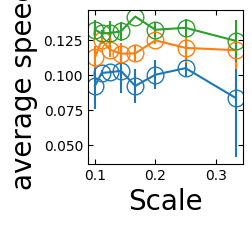

In [11]:
plt.figure(figsize=(2,2))
for i in range(len(Connecs)):
    plt.errorbar(1/SSs,np.mean(SPEED[:,i,:],1),yerr=np.std(SPEED[:,i,:],1),marker='o',markersize=12,fillstyle='none')
plt.xlabel('Scale',fontsize=20)
plt.ylabel('average speed',fontsize=20)
#plt.xlim([0.25,1])
#plt.ylim([-0.03,0.4])
plt.tick_params(direction='in',top='true',right='true')
plt.savefig('DistanceTime_Scale_1.pdf')
plt.show()

In [12]:
SPEEDAB=np.zeros((len(Entropy),len(Connecs),repeats))
for xcv in range(len(Connecs)):
    for i in range(len(SSs)):
        for kk in range(repeats):
            pin=np.size(TIME,1)
            for j in np.arange(1,np.size(TIME,1),1):
                if TIME[i,j,xcv,kk]==0:
                    pin=j
                    break
            z=np.polyfit(TIME[i,range(max(20,min(pin,100))),xcv,kk],BBB[i,range(max(20,min(pin,100))),xcv,kk],1)
            xcd=BBB[i,max(20,min(pin,100)),xcv,kk]/TIME[i,max(20,min(pin,100)),xcv,kk]
            SPEEDAB[i,xcv,kk]=xcd#z[0]

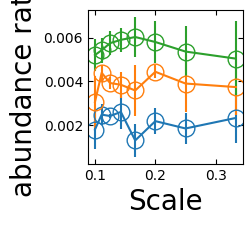

In [13]:
plt.figure(figsize=(2,2))
for i in range(len(Connecs)):
    plt.errorbar(1/SSs,np.mean(SPEEDAB[:,i,:],1),yerr=np.std(SPEEDAB[:,i,:],1),marker='o',markersize=12,fillstyle='none')
plt.xlabel('Scale',fontsize=20)
plt.ylabel('abundance rate',fontsize=20)
#plt.xlim([0.25,1])
#plt.ylim([-0.0002,0.0022])
plt.tick_params(direction='in',top='true',right='true')
plt.savefig('DistanceTime_Scale_2.pdf')
plt.show()

In [14]:
SPEEDFF=np.zeros((len(Entropy),len(Connecs),repeats))
for xcv in range(len(Connecs)):
    for i in range(len(SSs)):
        for kk in range(repeats):
            pin=np.size(TIME,1)
            for j in np.arange(1,np.size(TIME,1),1):
                if TIME[i,j,xcv,kk]==0:
                    pin=j
                    break
            z=np.polyfit(TIME[i,range(max(20,min(pin,100))),xcv,kk],FFF[i,range(max(20,min(pin,100))),xcv,kk],1)
            xcd=FFF[i,max(20,min(pin,100)),xcv,kk]/TIME[i,max(20,min(pin,100)),xcv,kk]
            SPEEDFF[i,xcv,kk]=xcd#z[0]

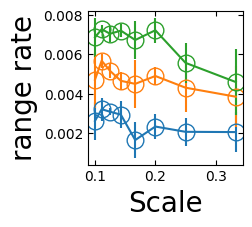

In [15]:
plt.figure(figsize=(2,2))
for i in range(len(Connecs)):
    plt.errorbar(1/SSs,np.mean(SPEEDFF[:,i,:],1),yerr=np.std(SPEEDFF[:,i,:],1),marker='o',markersize=12,fillstyle='none')
plt.xlabel('Scale',fontsize=20)
plt.ylabel('range rate',fontsize=20)
#plt.xlim([0.25,1])
#plt.ylim([-0.0002,0.0022])
plt.tick_params(direction='in',top='true',right='true')
plt.savefig('DistanceTime_Scale_3.pdf')
plt.show()